Many companies use autoML for predictive modeling and to gain insights from their data. AutoML tools such as auto-sklearn are useful for establishing an accurate baseline model at the start of a new project. I decided to build a custom autoML tool tailored to my specific needs. These include being able to create accurate models from a wide range of data and visualize how model features influence a particular outcome.

In this post, I demo my tool by testing it on some popular datasets. I show how the tool can produce plots for model evaluation and interpretation. Finally, I show that the tool can also be used for time series problems. 

## Benchmarking the AutoML Tool

I benchmark my autoML tool using the canonical Titanic dataset. This dataset contains demographic and ticket information for several hundred passengers of the Titanic. The outcome is whether a passenger survived the disaster. 

After importing the automl_tool package and preparing the data, I run the `fit_pipeline` method from the automl_tool package. Before fitting the model, I convert the Name feature to a pandas `String` dtype. The automl tool preprocesses features differently depending on the dtype. `String` columns are sent through scikit-learn's `CountVectorizer`.

In [33]:
# Install and import automl_tool
# !pip install git+https://github.com/andrewcarr24/automl_tool.git
from automl_tool import AutoML
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read data 
titanic_train = pd.read_csv("input_data/titanic_train.csv")

# Split titanic_train into X and y
X = (titanic_train
.assign(Name = lambda df_: df_["Name"].astype(pd.StringDtype()))
.drop("Survived", axis=1)
)
y = titanic_train["Survived"]

# Create AutoML instance with X and y and find best model
titanic_automl = AutoML(X, y, "Survived")
titanic_automl.fit_pipeline()

The `fit_pipeline` method fits a scikit-learn `GridSearchCV` metaestimator, which takes a `Pipeline` meta-estimator and performs 5-fold cross validation to select the best model from a set of XGBoost and linear (with l1 and l2 regularization) models. The best model is stored as an attribute called `fitted_pipeline`.

In [34]:
titanic_automl.fitted_pipeline

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='cons...
                          'model__learning_rate': [0.08],
                          'model__max_depth': [2, 3],
                          'model__n_estimators': [1000]},
                         {'model': [SGDClassifier(loss='log_loss',
                                                  penalty='elasticnet')],
                          'model__alpha': [0.1, 0.01, 0.005, 0.001, 1e-05,
                                           5e-06],
                          'model__l1_ratio': [0, 0.05, 0.1, 0.5, 0.8, 1],
                          'model__max_iter': [3000]}],
             scoring=make_scorer(log_loss, greater_is_better=False, response_method='predict_proba'))

The selected estimator is a ridge regresssor (click the arrow beside SGDClassifier to view model hyperparameters - this model has an l1_ratio of 0, meaning all regularization comes from the l2 penalty term).

How does this model compare to models that others have built? To answer this, I get predictions on the test data and submit these to Kaggle.

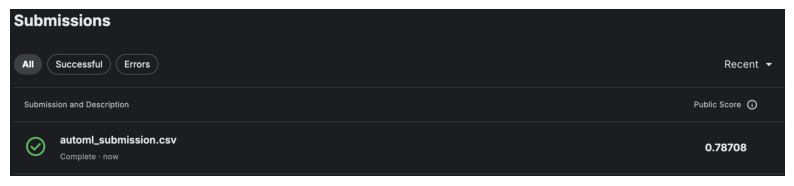

In [35]:
# titanic_test
X_test = (pd.read_csv("input_data/titanic_test.csv")
.assign(Name = lambda df_: df_["Name"].astype(pd.StringDtype()))
)

# Get predictions, create submission table and write to output_data 
titanic_preds = titanic_automl.fitted_pipeline.predict(X_test)
submission = pd.DataFrame({"PassengerId":X_test["PassengerId"], "Survived":titanic_preds})
submission.to_csv("output_data/automl_titanic_submission.csv", index=False)

img = mpimg.imread('img/automl_titanic_performance.png')
plt.figure(figsize=(10, 6))  
imgplot = plt.imshow(img)
plt.axis('off')   
plt.show()  

The model correctly predicted survival for 78.7% of passengers. This histogram of others' accuracy scores helps to contextualize this score (source: https://www.kaggle.com/competitions/titanic/discussion/57447). 

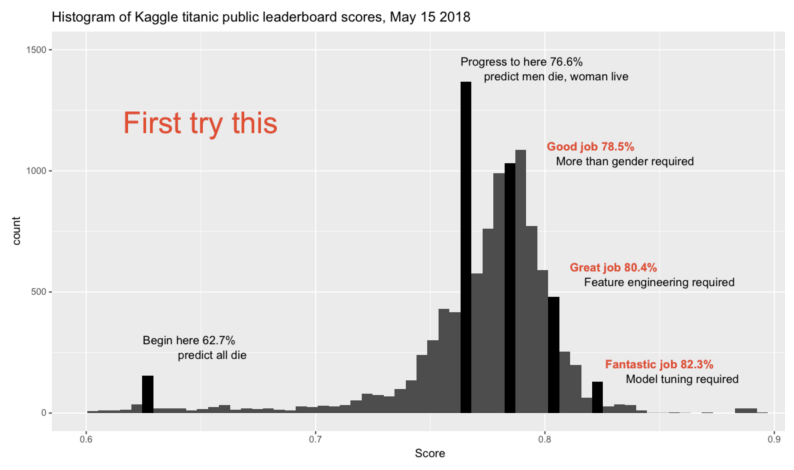

In [9]:
img = mpimg.imread('img/titanic_score_hist.png')
plt.figure(figsize=(10, 6))  
imgplot = plt.imshow(img)
plt.axis('off')   
plt.show()  

The model did slightly better than a "Good job", which is very good considering that we did no feature engineering beyond `auto_ml`'s automated preprocessing.

## Feature importance and feature effects

What were the most important features in our model? The `automl_tool` has a `get_feature_importance_scores` method that uses Shapley values to compute feature importance scores and a `plot_feature_importance` method to plot a ranking of these features. The tool also has an option to compute feature importance scores using permutation importance.

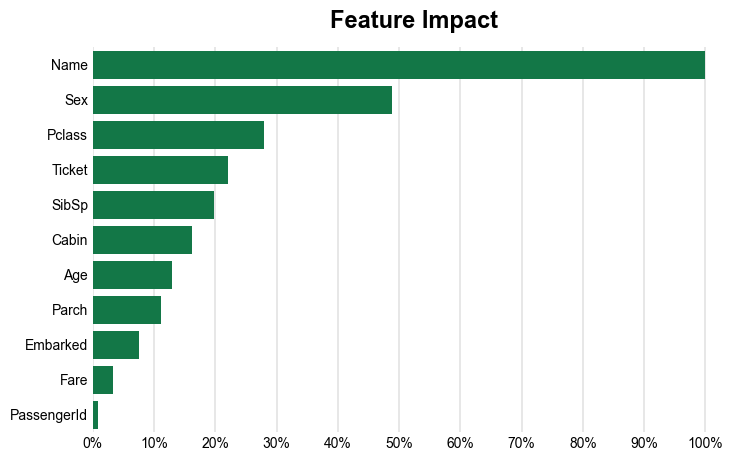

In [36]:
titanic_automl.get_feature_importance_scores()
titanic_automl.plot_feature_importance_scores()
titanic_automl.feature_importance_plot

`Name` is the most important feature in the model. Passenger name captures many demographic dimensions that mattered for surviving the Titanic disaster (sex, age, and class).

It is crucial to convert the `Name` feature to a string so that the tool knows to use the `CountVectorizer` preprocessor. This creates a set of columns based on the number of unique words across the corpus of passenger names. Each column gives a count of the number of times a word appears in a name. 

To see how features relate to the outcome, use the `get_partial_dependence_plots` method. This creates a dictionary of plots, the `partial_dependence_plots` attribute. 

In [37]:
titanic_automl.get_partial_dependence_plots()
titanic_automl.partial_dependence_plots

{'PassengerId': <Figure size 800x450 with 1 Axes>,
 'Pclass': <Figure size 800x450 with 1 Axes>,
 'Sex': <Figure size 550x450 with 1 Axes>,
 'Age': <Figure size 800x450 with 1 Axes>,
 'SibSp': <Figure size 800x450 with 1 Axes>,
 'Parch': <Figure size 800x450 with 1 Axes>,
 'Ticket': <Figure size 1150x450 with 1 Axes>,
 'Fare': <Figure size 800x450 with 1 Axes>,
 'Cabin': <Figure size 600x450 with 1 Axes>,
 'Embarked': <Figure size 600x450 with 1 Axes>}

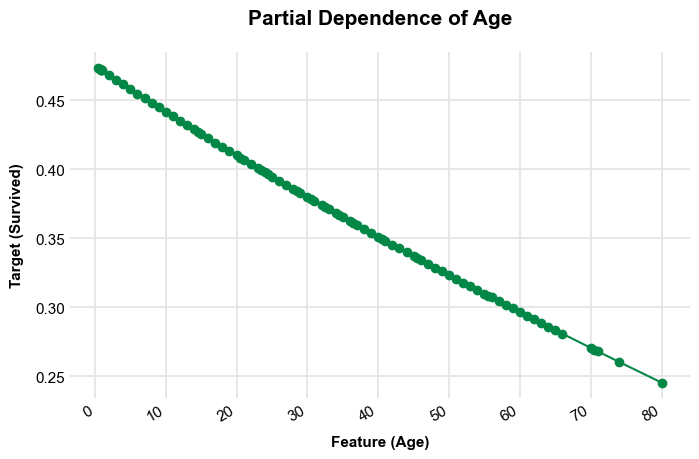

In [14]:
titanic_automl.partial_dependence_plots['Age']

This tool can also handle regression tasks. Whether the `fit_pipeline` performs classification or regression depends on the `dtype` of the outcome variable. Classification models are used for `int` outcomes, and regression models are used for `float` outcomes. 

## Time Series

This tool works great for classification and regression problems, but what about time series? To apply machine learning methods to time series data, two things need to be taken into consideration. First, time series methods like ARIMA use lags of the dependent variable as predictors. A time series model may include hundreds of features derived from the dependent variable, such as lags at various time points, logarithmic transformations of these lags, and rolling averages. 

My autoML tool has a helper function called `ts_train_test_split` that applies these transformations to a time series dataset. The function takes an input dataset, an outcome variable, the names of the outcome and date fields, and two additional parameters for deriving features: `fdw` and `holdout_window`. `fdw`, the feature derivation window, determines the number of time periods used to derive features. For example, if `fdw`=12, `ts_train_test_split` will create 12 lags of the dependent variable (columns lagged 1 to 12 periods from the period of a given row), 12 log lags, and so on. The `holdout_window` parameter determines the split between the training set and the holdout set.

The second thing that needs to be taken into consideration is how the method splits the data into training, validation, and holdout sets. The autoML tool handles this in two ways. First, `ts_train_test_split` uses the `holdout_window` parameter to let the user specify the number of periods to set aside for point-in-time backtesting. These periods come at the end of the time series dataset. Second, instead of using traditional five-fold cross validation, GridSearchCV uses an instance of `TimeSeriesSplit` to perform cross-validation. `TimeSeriesSplit` performs a special form of k-fold cross validation, using an expanding window as the training data and validating on time ranges that come after the training data (you can find a visualization of this at the bottom of [this page](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html).  

I demonstrate my autoML tool's time series capabilities by testing it on an electric and gas production dataset from a Federal Reserve index of industrial production (https://fred.stlouisfed.org/series/IPG2211A2N). The data is monthly and ranges from 1985 to 2018.

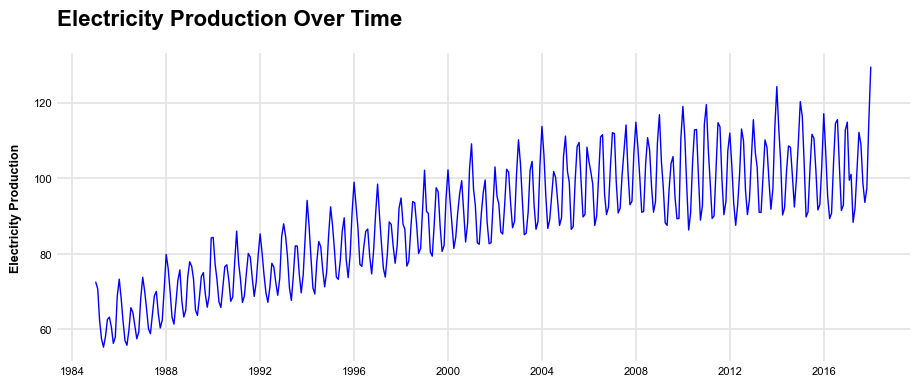

In [14]:
from automl_tool.preprocessing import ts_train_test_split

electric_tbl = pd.read_csv("input_data/electric_production.csv")

plt.style.use("opinionated_rc")
plt.rcParams.update({'grid.linestyle': '-',})

# Convert date column to datetime format 
electric_tbl['date'] = pd.to_datetime(electric_tbl['date'])

# Plot the data
plt.figure(figsize=(11, 4))
plt.plot(electric_tbl['date'], electric_tbl['electricity_production'],
 label='Electricity Production', color='blue', linewidth = 1)

# Add labels and title
plt.ylabel('Electricity Production', size = 9, loc = 'center')
plt.title('Electricity Production Over Time', size = 16)

# Set axis tick fontsize 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Show the plot
plt.show()

Here are the first few rows of the data before and after applying `ts_train_test_split`.

In [15]:
electric_tbl.head(3)

,date,electricity_production
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502


In [20]:
# Input dataframe and outcome variable (note - input dataframe includes outcome)
X, y = electric_tbl, electric_tbl["electricity_production"]

# Outcome variable and date names 
outcome_var, date_var = "electricity_production", "date"

# Feature derivation and holdout windows
fdw, holdout_window = 18, 24

X_train, X_holdout, y_train, y_holdout = ts_train_test_split(X, y, outcome_var,
 date_var, fdw, holdout_window)

X_train.head(3)

,lagged_electricity_production_1m,lagged_electricity_production_2m,lagged_electricity_production_3m,lagged_electricity_production_4m,lagged_electricity_production_5m,lagged_electricity_production_6m,lagged_electricity_production_7m,lagged_electricity_production_8m,lagged_electricity_production_9m,lagged_electricity_production_10m,lagged_electricity_production_11m,lagged_electricity_production_12m,lagged_electricity_production_13m,lagged_electricity_production_14m,lagged_electricity_production_15m,lagged_electricity_production_16m,lagged_electricity_production_17m,lagged_electricity_production_18m,logged_lagged_electricity_production_1m,logged_lagged_electricity_production_2m,logged_lagged_electricity_production_3m,logged_lagged_electricity_production_4m,logged_lagged_electricity_production_5m,logged_lagged_electricity_production_6m,logged_lagged_electricity_production_7m,logged_lagged_electricity_production_8m,logged_lagged_electricity_production_9m,logged_lagged_electricity_production_10m,logged_lagged_electricity_production_11m,logged_lagged_electricity_production_12m,logged_lagged_electricity_production_13m,logged_lagged_electricity_production_14m,logged_lagged_electricity_production_15m,logged_lagged_electricity_production_16m,logged_lagged_electricity_production_17m,logged_lagged_electricity_production_18m,rolling_avg_electricity_production_1m,rolling_avg_electricity_production_2m,rolling_avg_electricity_production_3m,rolling_avg_electricity_production_4m,rolling_avg_electricity_production_5m,rolling_avg_electricity_production_6m,rolling_avg_electricity_production_7m,rolling_avg_electricity_production_8m,rolling_avg_electricity_production_9m,rolling_avg_electricity_production_10m,rolling_avg_electricity_production_11m,rolling_avg_electricity_production_12m,rolling_avg_electricity_production_13m,rolling_avg_electricity_production_14m,rolling_avg_electricity_production_15m,rolling_avg_electricity_production_16m,rolling_avg_electricity_production_17m,rolling_avg_electricity_production_18m,min_electricity_production_1m,min_electricity_production_2m,min_electricity_production_3m,min_electricity_production_4m,min_electricity_production_5m,min_electricity_production_6m,min_electricity_production_7m,min_electricity_production_8m,min_electricity_production_9m,min_electricity_production_10m,min_electricity_production_11m,min_electricity_production_12m,min_electricity_production_13m,min_electricity_production_14m,min_electricity_production_15m,min_electricity_production_16m,min_electricity_production_17m,min_electricity_production_18m
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1986-07-01,59.9005,55.8137,57.0329,62.2221,67.9869,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,62.4502,70.6720,72.5052,4.109241,4.039777,4.061010,4.146654,4.233917,4.308188,4.244408,4.077546,4.048569,4.120412,4.162758,4.152931,4.079068,4.030963,4.068538,4.150255,4.272100,4.297356,59.9005,57.85710,57.582367,58.742300,60.59122,62.710300,63.568043,62.872100,62.143578,61.98768,62.102300,62.145458,61.833531,61.367929,61.10816,61.192038,61.749682,62.347211,59.9005,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.3151,55.3151,55.3151,55.3151,55.3151
1986-08-01,65.7655,59.9005,55.8137,57.0329,62.2221,67.9869,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,62.4502,70.6720,4.201186,4.109241,4.039777,4.061010,4.146654,4.233917,4.308188,4.244408,4.077546,4.048569,4.120412,4.162758,4.152931,4.079068,4.030963,4.068538,4.150255,4.272100,65.7655,62.83300,60.493233,59.628150,60.14694,61.453600,63.146757,63.842725,63.193589,62.50577,62.331118,62.407567,62.423923,62.114386,61.66110,61.399244,61.461065,61.972783,65.7655,59.9005,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.8137,55.3151,55.3151,55.3151,55.3151
1986-09-01,64.4816,65.7655,59.9005,55.8137,57.0329,62.2221,67.9869,73.3057,68.

Because I set the feature derivation window to 18, the date of `X_train` starts 18 months after the start of the original dataset.

Next, I create an `AutoML` instance with the transformed data and set the `time_series` parameter to `True`.  

In [21]:
electric_automl_estimator = AutoML(X_train, y_train, "electricity_production", time_series=True)

Because training requires specifying a holdout window for the validation sets used in cross validation, the `holdout_window` parameter must be set in the `fit_pipeline` for time series models, 

In [24]:
electric_automl_estimator.fit_pipeline(holdout_window=holdout_window)
electric_automl_estimator.fitted_pipeline

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=24),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['lagged_electricity_production_1m', 'lagged_electricity_production_2m',
       'lagged_electricit...
                          'model__early_stopping_rounds': [5],
                          'model__learning_rate': [0.08],
                          'model__max_depth': [2, 3],
                          'model__n_estimators': [1000]},
                         {'model': [SGDRegressor(penalty='elasticnet')],
                          'model__alpha': [0.1, 0.01, 0.005, 0.001, 1e-05,
                                           5e-06],
                          'model__l1_ratio': [0, 0.05, 0.1, 0.5, 0.8, 1],
                          'model__max_iter': [3000]}],
             scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'))

As with conventional models, the fitted `AutoML` class has methods for computing and visualizing the feature importance scores and feature effects of the best model. In addition, the fitted time series estimator includes a method for plotting the backtests of the selected model.

In [29]:
electric_automl_estimator.get_backtest_plots()
electric_automl_estimator.backtest_plots

{'bt1': <Figure size 2000x500 with 1 Axes>,
 'bt2': <Figure size 2000x500 with 1 Axes>,
 'bt3': <Figure size 2000x500 with 1 Axes>,
 'bt4': <Figure size 2000x500 with 1 Axes>,
 'bt5': <Figure size 2000x500 with 1 Axes>}

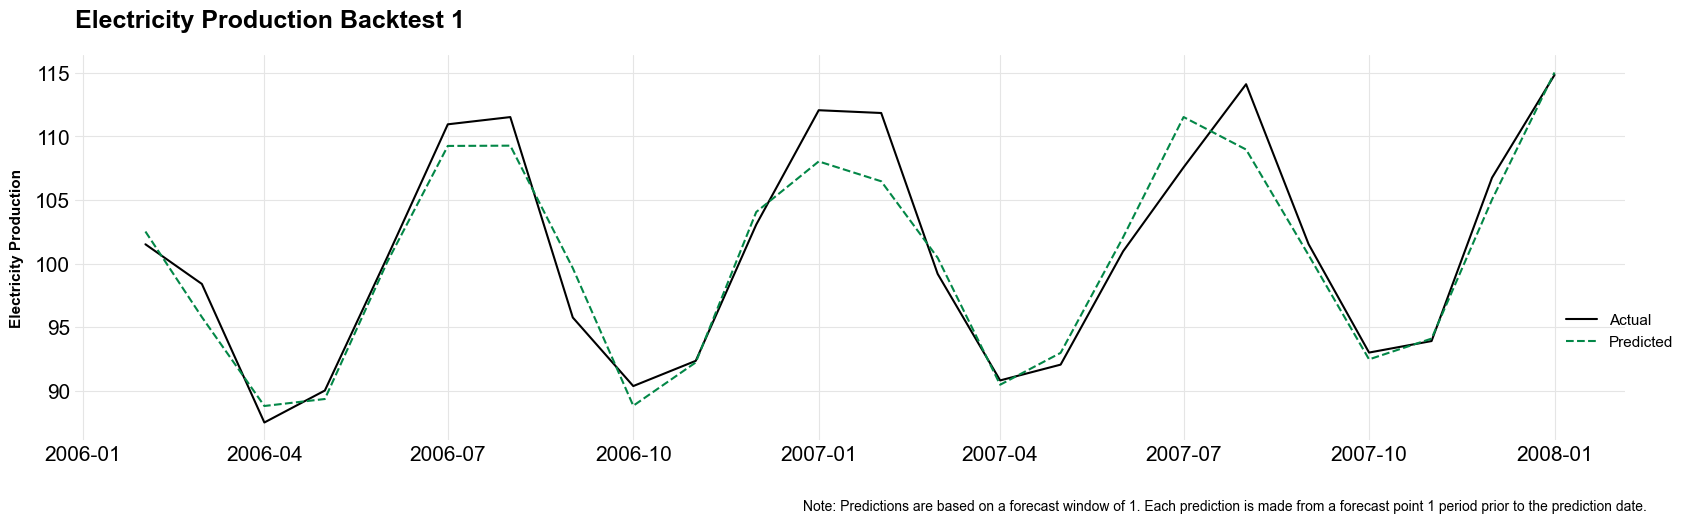

In [30]:
electric_automl_estimator.backtest_plots['bt1']

We can use the holdout data from `ts_train_test_split` to conduct a point-in-time backtest (a backtest on data that was not used for either training or validation).

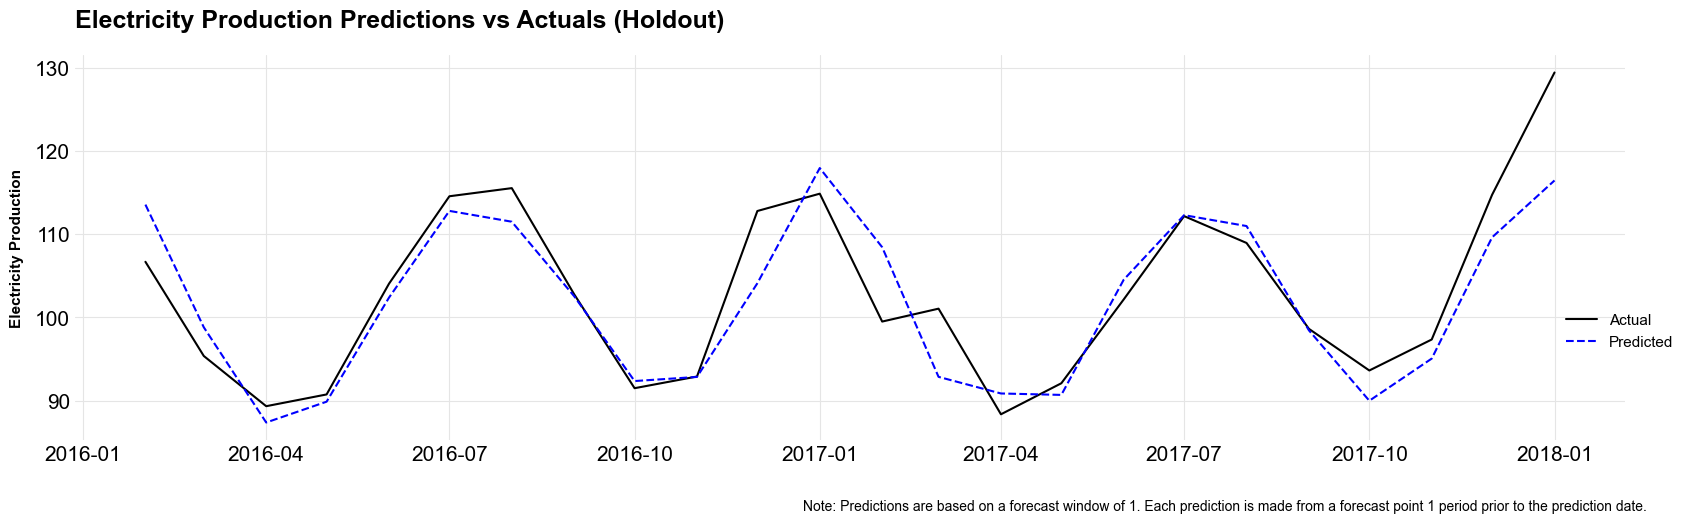

In [31]:
# Get holdout predictions
ts_preds = electric_automl_estimator.fitted_pipeline.best_estimator_.predict(X_holdout)

# Get actuals
actual_values = y_holdout.to_numpy()

# Create a figure with a longer size
fig, ax = plt.subplots(figsize=(20, 5))  # Adjust the width and height as needed
# plt.style.use("opinionated_rc")

# Plot the actuals
ax.plot(X_holdout.index, actual_values, label='Actual', color='black')

# Plot the predicted values
ax.plot(X_holdout.index, ts_preds, label='Predicted', color='blue', linestyle='dashed')

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Electricity Production', size = 11, loc = 'center')
ax.set_title('Electricity Production Predictions vs Actuals (Holdout)', size=18)

# Add a legend and nudge it down to the lower right
ax.legend(fontsize=11, loc='lower right', bbox_to_anchor=(1.04, .2))

# Add a caption
fig.text(0.7, -0.03, "Note: Predictions are based on a forecast window of 1. Each prediction is made from a forecast point 1 period prior to the prediction date.", wrap=True, horizontalalignment='center', fontsize=10)

# Customize gridlines to be solid
ax.grid(True, which='both', linestyle='-', linewidth=0.8)

# Show the plot
plt.show()

As mentioned in the plot caption, this tool currently can only build time series models with a forecast window of 1. In other words, the model can only predict one period into the future. I will add support for longer forecast windows as I add features to the tool.